# Segmenting and Clustering Neighborhoods in Bengaluru to identify a untapped location / Business venture

#### Import the required libraries and read the wiki page into html_doc variable

In [95]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from pandas.io.json import json_normalize 
import requests
import pandas as pd
import numpy as np

#!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

In [96]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  2.2.2


#### Read wiki page which has the location details

In [97]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

wiki_url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore"
results = requests.get(wiki_url)

html_doc = results.content

print("complete")

complete


#### Scrape through the page and identify the neighbourhood and region details based on the page format.

In [98]:
soup = BeautifulSoup(html_doc, 'html.parser')
#print(soup.prettify())

## Based on the page layout the following code will retrieve the 8 regions present in the page
reg_table = soup.find_all('li', limit=8) # read the 8 regions based on the available html page
reg_data =[]
final_data = []
for data in reg_table:
    var = data.find_all('span', attrs={'class':'toctext'})
    var = [ele.text.strip() for ele in var]
    reg_data.append([ele for ele in var if ele])

# Identify the table that holds details of the neighbourhoods in each of these regions.
table = soup.find_all('table', attrs={'class':'wikitable sortable'})

i=0
for table_data in table:
    table_body = table_data.find_all('tbody') ## required as data is present in multiple tables

    for table_data_region in table_body:
        rows = table_data_region.find_all('tr')
        for row in rows:
            cols = row.find_all('td', limit=1)
            cols = [ele.text.strip() for ele in cols]
            if len(cols) == 0:  ## skip blanks
                continue 
            else:
                final_data.append([cols[0],reg_data[i][0]]) ## append neighbourhood, region to the array
    
    i = i + 1
    
print(final_data[:15])

[['Cantonment area', 'Central'], ['Domlur', 'Central'], ['Indiranagar', 'Central'], ['Jeevanbheemanagar', 'Central'], ['Malleswaram', 'Central'], ['Pete area', 'Central'], ['Rajajinagar', 'Central'], ['Sadashivanagar', 'Central'], ['Seshadripuram', 'Central'], ['Shivajinagar', 'Central'], ['Ulsoor', 'Central'], ['Vasanth Nagar', 'Central'], ['Bellandur', 'Eastern'], ['CV Raman Nagar', 'Eastern'], ['Hoodi', 'Eastern']]


#### Cleanup array from blank data and append headers the array

In [99]:
data_new = []
data_new.append(['Neighbourhood','Region'])
for i in range(0,len(final_data)):
    if len(final_data[i]) == 0:
        continue
    else:
        data_new.append(final_data[i])   
print(data_new[0:15])

[['Neighbourhood', 'Region'], ['Cantonment area', 'Central'], ['Domlur', 'Central'], ['Indiranagar', 'Central'], ['Jeevanbheemanagar', 'Central'], ['Malleswaram', 'Central'], ['Pete area', 'Central'], ['Rajajinagar', 'Central'], ['Sadashivanagar', 'Central'], ['Seshadripuram', 'Central'], ['Shivajinagar', 'Central'], ['Ulsoor', 'Central'], ['Vasanth Nagar', 'Central'], ['Bellandur', 'Eastern'], ['CV Raman Nagar', 'Eastern']]


#### Convert the array to a dataframe for further processing

In [100]:
df = pd.DataFrame(data_new[1:],columns=data_new[0]) ## convert the array to a dataframe
df["latitude"] = "" ## add latitude and longitude columns
df["longitude"] = ""
df.set_index("Neighbourhood", inplace=True)

print("Dataframe shape : ",df.shape)
df.head()

Dataframe shape :  (64, 3)


,Region,latitude,longitude
Neighbourhood,,,
Cantonment area,Central,,
Domlur,Central,,
Indiranagar,Central,,
Jeevanbheemanagar,Central,,
Malleswaram,Central,,


#### Identify the co-ordinates Bangalore city

In [101]:
address = 'Bangalore'

geolocator = Nominatim()
location = geolocator.geocode(address)
bglr_latitude = location.latitude
bglr_longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(bglr_latitude, bglr_longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


#### Identify the co-ordinates for each neighborhood. For neighborhoods where geopy errors out, we clean the data from the dataframe.

In [102]:
geolocator = Nominatim()

#tmp_arr = df['Neighbourhood'].values ## get tbe values in to an array 
#for data in tmp_arr:

for data in df.index.values:

    address = str(data) + ', Bangalore'
    #print(address)
    location = geolocator.geocode(address)
    #print(location)
    try:
        latitude = location.latitude
        longitude = location.longitude
        #print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        df.loc[data, 'latitude'] = latitude
        df.loc[data, 'longitude'] = longitude
    except:
        print('########Location issues with {}. Dropping location.'.format(address))
        df.drop(index = data, inplace=True)
print('Done')

df.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


########Location issues with Jeevanbheemanagar, Bangalore. Dropping location.
########Location issues with Pete area, Bangalore. Dropping location.
########Location issues with CV Raman Nagar, Bangalore. Dropping location.
Done


,Region,latitude,longitude
Neighbourhood,,,
Cantonment area,Central,13.0196,77.5096
Domlur,Central,12.9625,77.6382
Indiranagar,Central,12.9733,77.6405
Malleswaram,Central,13.0163,77.5587
Rajajinagar,Central,12.9882,77.5549


In [108]:
df.shape

(63, 4)

63 Neighbourhoods are identified in the city of Bengaluru

#### Rectify the co-ordinates of few location to have an accurate data.

In [104]:
df.loc['Koramangala','latitude'] = 12.9354922
df.loc['Koramangala','longitude'] = 77.6146828
df.loc['Mahadevapura','latitude'] = 12.9869651
df.loc['Mahadevapura','longitude'] = 77.6687653
df.loc['Gottigere','latitude'] = 12.8540437
df.loc['Gottigere','longitude'] = 77.5809763
df.loc['Bommanahalli','latitude'] = 12.8540437
df.loc['Bommanahalli','longitude'] = 77.5809763

In [105]:
df.reset_index(inplace = True)

#### Lets add 2 neighbourhoods which were dropped due to issues in retrieving co-ordinates using geopy

In [106]:
#df_2 = pd.DataFrame([['CV Raman Nagar','Eastern',12.9829637,77.6526539], ['Jeevan Bima Nagar','Central',12.964964,77.653821]])
#df_2
# Pass a series in append() to append a row in dataframe  
df = df.append(pd.Series(['CV Raman Nagar','Eastern',12.9829637,77.6526539], index=df.columns ), ignore_index=True)
df = df.append(pd.Series(['Jeevan Bima Nagar','Central',12.964964,77.653821], index=df.columns ), ignore_index=True)

In [109]:
df.shape

(63, 4)

This makes a total of 63 neighbourhood data to work with

#### Summary of data available till now

In [110]:
df_plot_tmp = df[['Region','Neighbourhood']]
df_plot_tmp = df_plot_tmp.groupby('Region').count()
df_plot_tmp

,Neighbourhood
Region,
Central,11
Eastern,8
North-Eastern,6
Northern,8
South-Eastern,7
Southern,8
Southern suburbs,6
Western,9


#### Plot the map of the city of Bangalore along with its neighborhood

In [111]:
# create map of Manhattan using latitude and longitude values
map_bglr = folium.Map(location=[bglr_latitude, bglr_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['latitude'], df['longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bglr)  
    
map_bglr

#### Write data to csv only to be used later if required. The data is currently a clean data from a location perspective.

In [112]:
df.to_csv('bglr_location_data.csv')

In [113]:
df.head()

,Neighbourhood,Region,latitude,longitude
0,Cantonment area,Central,13.0196,77.5096
1,Domlur,Central,12.9625,77.6382
2,Indiranagar,Central,12.9733,77.6405
3,Malleswaram,Central,13.0163,77.5587
4,Rajajinagar,Central,12.9882,77.5549


#### Foursquare API settings

In [114]:
CLIENT_ID = "4OOCPYQHZDDIC4SMJCSMEIK0WR4GCM1FV1DPMWJEQHUV4B5F" # your Foursquare ID
CLIENT_SECRET = "ITFURGHEU5A4GJTNCNVHFIW4XKTDCXVEAWBYFHVCNHNIBFV3" # your Foursquare Secret
VERSION = '20180604'

#### Add additional columns for capturing data related to venues

In [115]:
df["venue_name"] = ""
df["venue_longitude"] = ""
df["venue_latitude"] = ""
df["venue_category"] = ""

In [116]:
df.head()

,Neighbourhood,Region,latitude,longitude,venue_name,venue_longitude,venue_latitude,venue_category
0,Cantonment area,Central,13.0196,77.5096,,,,
1,Domlur,Central,12.9625,77.6382,,,,
2,Indiranagar,Central,12.9733,77.6405,,,,
3,Malleswaram,Central,13.0163,77.5587,,,,
4,Rajajinagar,Central,12.9882,77.5549,,,,


In [117]:
df.columns

Index(['Neighbourhood', 'Region', 'latitude', 'longitude', 'venue_name',
       'venue_longitude', 'venue_latitude', 'venue_category'],
      dtype='object')

#### Loop over all the neighborhoods and capture the venues in a radius of 1000m.

In [119]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

n_data = [['Neighbourhood','Region','latitude','longitude','venue_name','venue_longitude','venue_latitude','venue_category']]
for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)
    print("Loading neighbourhood data for {}.".format(row['Neighbourhood']))
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        venue_name = v['venue']['name']
        venue_lat = v['venue']['location']['lat']
        venue_lng = v['venue']['location']['lng']
        venue_categ = v['venue']['categories'][0]['name']
        n_data.append([row['Neighbourhood'],row['Region'],row['latitude'],row['longitude'],venue_name,venue_lat,venue_lng,venue_categ])
        
df_consolidated = pd.DataFrame(n_data[1:],columns=n_data[0]) ## convert the array to a dataframe

Loading neighbourhood data for Cantonment area.
Loading neighbourhood data for Domlur.
Loading neighbourhood data for Indiranagar.
Loading neighbourhood data for Malleswaram.
Loading neighbourhood data for Rajajinagar.
Loading neighbourhood data for Sadashivanagar.
Loading neighbourhood data for Seshadripuram.
Loading neighbourhood data for Shivajinagar.
Loading neighbourhood data for Ulsoor.
Loading neighbourhood data for Vasanth Nagar.
Loading neighbourhood data for Bellandur.
Loading neighbourhood data for Hoodi.
Loading neighbourhood data for Krishnarajapuram.
Loading neighbourhood data for Mahadevapura.
Loading neighbourhood data for Marathahalli.
Loading neighbourhood data for Varthur.
Loading neighbourhood data for Whitefield.
Loading neighbourhood data for Banaswadi.
Loading neighbourhood data for HBR Layout.
Loading neighbourhood data for Horamavu.
Loading neighbourhood data for Kammanahalli.
Loading neighbourhood data for Lingarajapuram.
Loading neighbourhood data for Ramamur

In [120]:
df_consolidated.head()

,Neighbourhood,Region,latitude,longitude,venue_name,venue_longitude,venue_latitude,venue_category
0,Cantonment area,Central,13.019567,77.509589,bhat canteen,13.016796,77.504154,Fast Food Restaurant
1,Domlur,Central,12.962467,77.638196,Lavonne,12.963909,77.638579,Café
2,Domlur,Central,12.962467,77.638196,Barbeque Nation,12.962684,77.641599,BBQ Joint
3,Domlur,Central,12.962467,77.638196,Smoke House Deli,12.965584,77.641498,Deli / Bodega
4,Domlur,Central,12.962467,77.638196,Starbucks,12.965649,77.641718,Coffee Shop


In [121]:
df_consolidated.set_index(['Neighbourhood'], inplace = True)

In [123]:
print(df_consolidated.shape)
df_consolidated.head()

(1748, 7)


,Region,latitude,longitude,venue_name,venue_longitude,venue_latitude,venue_category
Neighbourhood,,,,,,,
Cantonment area,Central,13.019567,77.509589,bhat canteen,13.016796,77.504154,Fast Food Restaurant
Domlur,Central,12.962467,77.638196,Lavonne,12.963909,77.638579,Café
Domlur,Central,12.962467,77.638196,Barbeque Nation,12.962684,77.641599,BBQ Joint
Domlur,Central,12.962467,77.638196,Smoke House Deli,12.965584,77.641498,Deli / Bodega
Domlur,Central,12.962467,77.638196,Starbucks,12.965649,77.641718,Coffee Shop


In [124]:
df_consolidated.groupby('Neighbourhood').count()

,Region,latitude,longitude,venue_name,venue_longitude,venue_latitude,venue_category
Neighbourhood,,,,,,,
Anjanapura,2,2,2,2,2,2,2
Arekere,35,35,35,35,35,35,35
BTM Layout,44,44,44,44,44,44,44
Banashankari,27,27,27,27,27,27,27
Banaswadi,19,19,19,19,19,19,19
Basavanagudi,48,48,48,48,48,48,48
Basaveshwaranagar,19,19,19,19,19,19,19
Begur,7,7,7,7,7,7,7
Bellandur,68,68,68,68,68,68,68


In [125]:
print('There are {} uniques categories.'.format(len(df_consolidated['venue_category'].unique())))

There are 182 uniques categories.


Dropping area where the count of venues are less than 10

In [139]:
df_consolidated.drop('Cantonment area', inplace = True)
df_consolidated.drop('Kothnur', inplace = True)
df_consolidated.drop('Peenya', inplace = True)

In [140]:
df_tmp = df_consolidated.groupby('Neighbourhood').count()

df_tmp.reset_index(inplace=True)
df_tmp = df_tmp[['Neighbourhood','venue_category']]

df_tmp = df_tmp[(df_tmp.venue_category >= 10)]
df_tmp.drop('venue_category', axis = 1, inplace = True)
df_tmp = df_tmp.join(df_consolidated, on = 'Neighbourhood')
print("Total Neighbourhoods : ",len(df_tmp['Neighbourhood'].unique()))



Total Neighbourhoods :  43


Breakup of the number of neighbourhood in each region

In [142]:
df_plot_tmp = df_tmp[['Region','Neighbourhood']]
df_plot_tmp = df_plot_tmp.groupby('Region').count()
df_plot_tmp

,Neighbourhood
Region,
Central,599
Eastern,178
North-Eastern,68
Northern,77
South-Eastern,315
Southern,253
Southern suburbs,74
Western,67


Plot a bar graph of number of venu categories idenitified per neighbourhood

In [143]:
df_plot_tmp = df_tmp.copy(deep = True)
df_plot_tmp.reset_index(inplace = True)
df_plot_tmp = df_plot_tmp[['Neighbourhood','venue_category']]
df_plot_tmp = df_plot_tmp.groupby('Neighbourhood').count()

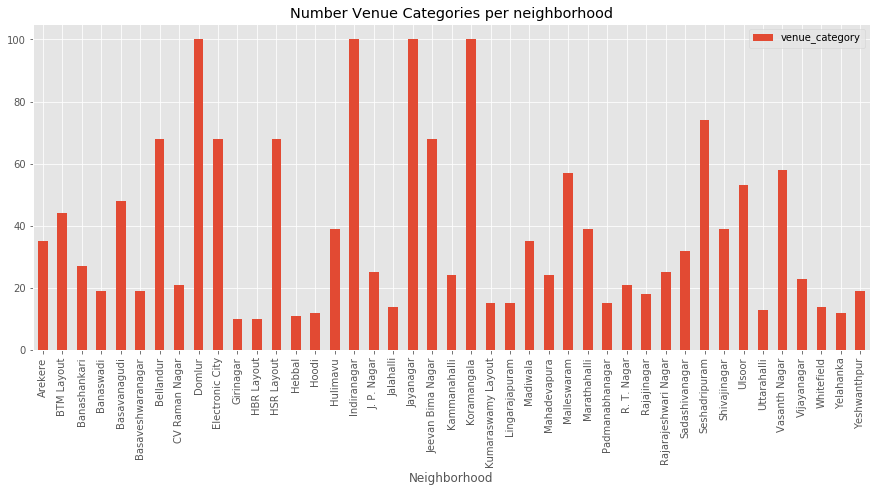

In [144]:
df_plot_tmp.plot(kind='bar', figsize=(15, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
#plt.ylabel('Number of Venue Categories') # add y-label to the plot
plt.title('Number Venue Categories per neighborhood') # add title to the plot

plt.show()

In [145]:
df_consolidated = df_tmp.copy(deep = True)
df_consolidated.head()

,Neighbourhood,Region,latitude,longitude,venue_name,venue_longitude,venue_latitude,venue_category
1,Arekere,Southern suburbs,12.87847,77.604179,Ingu Tengu,12.883268,77.607514,South Indian Restaurant
1,Arekere,Southern suburbs,12.87847,77.604179,Cinepolis,12.876119,77.595455,Multiplex
1,Arekere,Southern suburbs,12.87847,77.604179,Swensens,12.876071,77.595542,Ice Cream Shop
1,Arekere,Southern suburbs,12.87847,77.604179,Simply Indian,12.879523,77.609748,Indian Restaurant
1,Arekere,Southern suburbs,12.87847,77.604179,Royal Meenakshi Mall,12.876093,77.595479,Shopping Mall


#### Analyze each neighborhood.

In [146]:
# one hot encoding
bglr_onehot = pd.get_dummies(df_consolidated[['venue_category']], prefix="", prefix_sep="")

bglr_onehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
bglr_onehot.shape

(1631, 174)

In [148]:
# add neighborhood column back to dataframe
bglr_onehot['Neighbourhood'] = df_consolidated['Neighbourhood'] 

In [149]:
bglr_onehot.shape

(1631, 175)

In [150]:
bglr_onehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Thai Restaurant,Tibetan Restaurant,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio,Neighbourhood
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arekere
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arekere
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arekere
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arekere
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arekere


In [151]:
bglr_grouped = bglr_onehot.groupby('Neighbourhood').mean().reset_index()
bglr_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,Arekere,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,BTM Layout,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0
2,Banashankari,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0
3,Banaswadi,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.052632,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0
4,Basavanagudi,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


#### Lets identify the best number of cluster with least classification error.

In [152]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Assign the independent variables to X

In [153]:
bglr_grouped_clustering = bglr_grouped.drop('Neighbourhood', 1)
X = bglr_grouped_clustering.values

Loop over cluster from 2 to 12 and identify the accuracy for each of the cluster value

In [154]:
# set number of clusters
kclusters = list(range(2,12))

accuracy_arr = []
cv_scores = []
for k in kclusters:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(bglr_grouped_clustering)
    y = kmeans.labels_

    #k_means_labels = kmeans.labels_
    #k_means_cluster_centers = kmeans.cluster_centers_
    
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    #tmp_arr = [k,scores.mean()]
    accuracy_arr.append([k,scores.mean()])
cv_scores

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 m

[0.8158730158730159,
 0.8011111111111111,
 0.8051298701298701,
 0.8076190476190476,
 0.7506854256854257,
 0.778907203907204,
 0.6690476190476191,
 0.6012698412698413,
 0.5047619047619047,
 0.6428571428571429]

#### Identify MSE for each and get the optimal cluster value

The optimal number of neighbors is  2


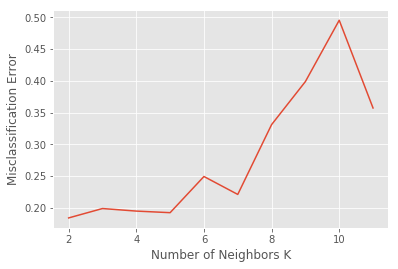

In [155]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = kclusters[MSE.index(min(MSE))]
print("The optimal number of neighbors is ", optimal_k)

# plot misclassification error vs k
plt.plot(kclusters, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [156]:
df_tmp = pd.DataFrame(MSE)
df_tmp.reset_index(inplace = True)
df_tmp.set_index('index', inplace = True)
df_tmp.rename({0:'MSE'}, axis='columns', inplace = True)

df_tmp_2 = pd.DataFrame(kclusters)
df_tmp_2.reset_index(inplace = True)
df_tmp_2.set_index('index', inplace = True)
df_tmp_2.rename({0:'KCluster'}, axis='columns', inplace = True)

df_tmp_3 = df_tmp.join(df_tmp_2, on = 'index')

df_tmp_3[['KCluster','MSE']]

,KCluster,MSE
index,,
0,2,0.184127
1,3,0.198889
2,4,0.194870
3,5,0.192381
4,6,0.249315
5,7,0.221093
6,8,0.330952
7,9,0.398730
8,10,0.495238


#### Using Kmeans, clustering the data into optimal segments.

In [157]:
# set number of clusters
kclusters = optimal_k

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bglr_grouped_clustering)

#### Add neighborhood and co-ordinate details to the cluster output dataframe

In [158]:
bglr_merged = bglr_grouped_clustering.copy(deep = True)

# add clustering labels
bglr_merged['Cluster Labels'] = kmeans.labels_
bglr_merged['Neighbourhood'] = bglr_grouped[['Neighbourhood']]

df_bglr_data_loc = df[['Neighbourhood','latitude','longitude']]

bglr_merged = bglr_merged.join(df_bglr_data_loc.set_index('Neighbourhood'), on='Neighbourhood')

bglr_merged.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio,Cluster Labels,Neighbourhood,latitude,longitude
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0,Arekere,12.8785,77.6042
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022727,0.0,...,0.0,0.0,0.090909,0.0,0.000000,0.0,1,BTM Layout,12.9152,77.6103
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.037037,0.0,1,Banashankari,12.9154,77.5736
3,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.052632,0.000000,0.0,...,0.0,0.0,0.052632,0.0,0.000000,0.0,0,Banaswadi,13.0142,77.6519
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020833,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1,Basavanagudi,12.9417,77.5755


#### Map the clusters on the city of Bengaluru

In [159]:
# create map
map_clusters = folium.Map(location=[bglr_latitude, bglr_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bglr_merged['latitude'], bglr_merged['longitude'], bglr_merged['Neighbourhood'], bglr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Analyze the cluster counts

In [160]:
neigh_arr = [['Cluster','Count','Regions']]
for i in range(0,kclusters):
    tmp_value = bglr_merged.loc[bglr_merged['Cluster Labels'] == i]['Neighbourhood'].values
    neigh_arr.append([i,len(tmp_value),tmp_value])
    #print(neigh_arr)
    
    
df_tmp = pd.DataFrame(neigh_arr[1:],columns=neigh_arr[0]) ## convert the array to a dataframe
df_tmp

,Cluster,Count,Regions
0,0,24,"[Arekere, Banaswadi, Bellandur, CV Raman Nagar..."
1,1,19,"[BTM Layout, Banashankari, Basavanagudi, Basav..."


In [161]:
bglr_merged.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio,Cluster Labels,Neighbourhood,latitude,longitude
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0,Arekere,12.8785,77.6042
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022727,0.0,...,0.0,0.0,0.090909,0.0,0.000000,0.0,1,BTM Layout,12.9152,77.6103
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.037037,0.0,1,Banashankari,12.9154,77.5736
3,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.052632,0.000000,0.0,...,0.0,0.0,0.052632,0.0,0.000000,0.0,0,Banaswadi,13.0142,77.6519
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020833,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1,Basavanagudi,12.9417,77.5755


#### Create function to identify the top 10 common venues for each neighborhood

In [162]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [165]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = bglr_grouped['Neighbourhood']

for ind in np.arange(bglr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bglr_grouped.iloc[ind, :], num_top_venues)


In [166]:
neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arekere,Café,Indian Restaurant,Movie Theater,Multiplex,South Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Electronics Store,Dumpling Restaurant,Italian Restaurant
1,BTM Layout,Indian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Bakery,Snack Place,Café,Sandwich Place,Chinese Restaurant,Pizza Place,Coffee Shop
2,Banashankari,Indian Restaurant,Fast Food Restaurant,Bakery,Ice Cream Shop,Café,Park,Breakfast Spot,Salad Place,Jewelry Store,Bus Stop
3,Banaswadi,Indian Restaurant,Café,Department Store,Kerala Restaurant,Market,Intersection,BBQ Joint,Bistro,Pizza Place,Seafood Restaurant
4,Basavanagudi,Indian Restaurant,Fast Food Restaurant,Café,Ice Cream Shop,Restaurant,Breakfast Spot,Sandwich Place,Bakery,Juice Bar,Italian Restaurant
5,Basaveshwaranagar,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pizza Place,Miscellaneous Shop,Department Store,Bagel Shop,Café,Mobile Phone Shop,Park
6,Bellandur,Indian Restaurant,Hotel,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Pizza Place,Mexican Restaurant,Electronics Store
7,CV Raman Nagar,Light Rail Station,Bus Station,Food Truck,Indian Restaurant,Café,Sandwich Place,Bookstore,Shopping Mall,Fast Food Restaurant,Butcher
8,Domlur,Indian Restaurant,Café,Pub,Italian Restaurant,Coffee Shop,Hotel,Restaurant,Lounge,Clothing Store,Pizza Place
9,Electronic City,Indian Restaurant,Hotel,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Pizza Place,Mexican Restaurant,Electronics Store


#### Based on the output, Clusters 0 and 1 have sufficient data to continue with the further analysis.

In [167]:
df_count_tmp = df_consolidated.copy(deep = True)
#df_count_tmp.shape
df_count_tmp.drop(['Region','latitude','longitude','venue_name','venue_longitude','venue_latitude','venue_category'], axis = 1, inplace = True)
df_count_tmp = df_count_tmp.groupby('Neighbourhood').size().reset_index(name='counts')
df_count_tmp.sort_values('counts', ascending = False, inplace = True)

#### Data for Cluster 0 - 10 most common venues for the top 5 neighbourhoods by count of venues available

In [168]:
df_bglr_data_tmp = bglr_merged[['Neighbourhood','latitude','longitude','Cluster Labels']]

df_bglr_data_tmp_2 = neighborhoods_venues_sorted.join(df_bglr_data_tmp.set_index('Neighbourhood'), on='Neighbourhood')
df_bglr_data_tmp_2 = df_bglr_data_tmp_2.join(df_count_tmp.set_index('Neighbourhood'), on='Neighbourhood')
df_bglr_data_tmp_2.loc[df_bglr_data_tmp_2['Cluster Labels'] == 0].sort_values('counts', ascending = False).head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Cluster Labels,counts
8,Domlur,Indian Restaurant,Café,Pub,Italian Restaurant,Coffee Shop,Hotel,Restaurant,Lounge,Clothing Store,Pizza Place,12.9625,77.6382,0,100
16,Indiranagar,Pub,Indian Restaurant,Ice Cream Shop,Lounge,Café,Bar,Cocktail Bar,Dessert Shop,Chinese Restaurant,Tea Room,12.9733,77.6405,0,100
22,Koramangala,Indian Restaurant,Café,Dessert Shop,Chinese Restaurant,Coffee Shop,Bar,Pub,Lounge,Bookstore,Italian Restaurant,12.9355,77.6147,0,100
34,Seshadripuram,Indian Restaurant,Clothing Store,Café,Ice Cream Shop,Hotel,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Karnataka Restaurant,Donut Shop,Gym,12.9932,77.5753,0,74
6,Bellandur,Indian Restaurant,Hotel,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Pizza Place,Mexican Restaurant,Electronics Store,12.9791,77.5913,0,68


#### Data for Cluster 1 - 10 most common venues for the top 5 neighbourhoods by count of venues available

In [169]:
df_bglr_data_tmp_2.loc[df_bglr_data_tmp_2['Cluster Labels'] == 1].head().sort_values('counts', ascending = False).head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Cluster Labels,counts
12,HSR Layout,Indian Restaurant,Café,Pizza Place,Park,Liquor Store,Ice Cream Shop,Snack Place,Chettinad Restaurant,Bakery,Department Store,12.9116,77.6389,1,68
4,Basavanagudi,Indian Restaurant,Fast Food Restaurant,Café,Ice Cream Shop,Restaurant,Breakfast Spot,Sandwich Place,Bakery,Juice Bar,Italian Restaurant,12.9417,77.5755,1,48
1,BTM Layout,Indian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Bakery,Snack Place,Café,Sandwich Place,Chinese Restaurant,Pizza Place,Coffee Shop,12.9152,77.6103,1,44
2,Banashankari,Indian Restaurant,Fast Food Restaurant,Bakery,Ice Cream Shop,Café,Park,Breakfast Spot,Salad Place,Jewelry Store,Bus Stop,12.9154,77.5736,1,27
5,Basaveshwaranagar,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pizza Place,Miscellaneous Shop,Department Store,Bagel Shop,Café,Mobile Phone Shop,Park,12.9865,77.5386,1,19


#### Lets analyze cluster 0 and 1 in detail, considering the number of areas in that cluster and identify venue categories related to food business

Creating dataframe and venue category string to be used in word cloud to identify frequently used venues

In [170]:
df_bglr_data_tmp_3 = bglr_merged[['Neighbourhood','Cluster Labels']].copy(deep = True)
df_bglr_data_tmp_4 = df_consolidated.copy(deep = True)

df_bglr_data_tmp_4 = df_bglr_data_tmp_4[['Neighbourhood','venue_category']]

df_bglr_data_tmp_4 = df_bglr_data_tmp_4.join(df_bglr_data_tmp_3.set_index('Neighbourhood'), on='Neighbourhood')
#df_bglr_data_tmp_4.head(10)

data_bglr_cluster_0 = df_bglr_data_tmp_4.loc[df_bglr_data_tmp_4['Cluster Labels'] == 0].copy(deep = True)
data_bglr_cluster_1 = df_bglr_data_tmp_4.loc[df_bglr_data_tmp_4['Cluster Labels'] == 1].copy(deep = True)

#data_bglr_cluster_0.reset_index(drop = True, inplace = True)

In [171]:
#final_str_clus4 = " "
#for str_tmp in data_bglr_cluster_4['venue_category'].tolist():
#    final_str_clus4 = final_str_clus4 + " " + str_tmp
    
final_str_clus1 = " "
for str_tmp in data_bglr_cluster_1['venue_category'].tolist():
    final_str_clus1 = final_str_clus1 + " " + str_tmp
    
final_str_clus0 = " "
for str_tmp in data_bglr_cluster_0['venue_category'].tolist():
    final_str_clus0 = final_str_clus0 + " " + str_tmp
    
#final_str    

In [172]:
data_bglr_cluster_1.head()

,Neighbourhood,venue_category,Cluster Labels
2,BTM Layout,Vegetarian / Vegan Restaurant,1
2,BTM Layout,Bakery,1
2,BTM Layout,Gym,1
2,BTM Layout,Burger Joint,1
2,BTM Layout,Restaurant,1


In [173]:
df_plot_tmp = data_bglr_cluster_0.copy(deep = True)
#df_plot_tmp.reset_index(inplace = True)
df_plot_tmp = df_plot_tmp[['Neighbourhood','venue_category']]
df_plot_tmp = df_plot_tmp.groupby('Neighbourhood').count()

In [174]:
df_plot_tmp

,venue_category
Neighbourhood,
Arekere,35
Banaswadi,19
Bellandur,68
CV Raman Nagar,21
Domlur,100
Electronic City,68
Girinagar,10
HBR Layout,10
Hoodi,12


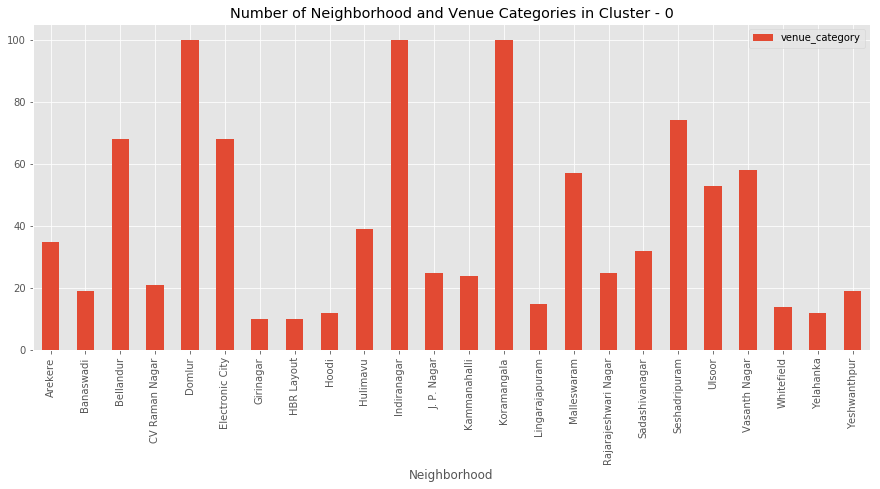

In [175]:
df_plot_tmp.plot(kind='bar', figsize=(15, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
#plt.ylabel('Number of Venue Categories') # add y-label to the plot
plt.title('Number of Neighborhood and Venue Categories in Cluster - 0') # add title to the plot

plt.show()

In [176]:
df_plot_tmp = data_bglr_cluster_1.copy(deep = True)
#df_plot_tmp.reset_index(inplace = True)
df_plot_tmp = df_plot_tmp[['Neighbourhood','venue_category']]
df_plot_tmp = df_plot_tmp.groupby('Neighbourhood').count()

In [177]:
df_plot_tmp

,venue_category
Neighbourhood,
BTM Layout,44
Banashankari,27
Basavanagudi,48
Basaveshwaranagar,19
HSR Layout,68
Hebbal,11
Jalahalli,14
Jayanagar,100
Jeevan Bima Nagar,68


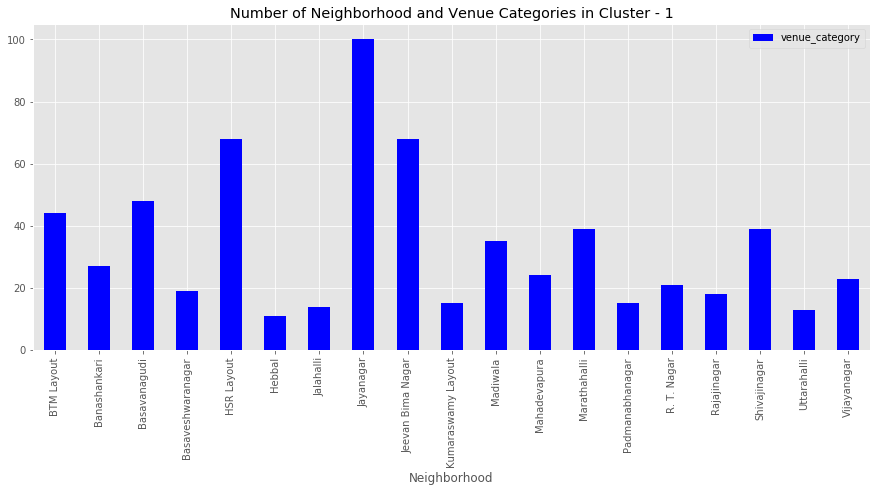

In [178]:
df_plot_tmp.plot(kind='bar', figsize=(15, 6), color='blue')

plt.xlabel('Neighborhood') # add to x-label to the plot
#plt.ylabel('Number of Venue Categories') # add y-label to the plot
plt.title('Number of Neighborhood and Venue Categories in Cluster - 1') # add title to the plot

plt.show()

In [179]:
stopwords = set(STOPWORDS)
stopwords.add('Restaurant')

In [180]:
# instantiate a word cloud object
venue_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

#### Word cloud for cluster 1

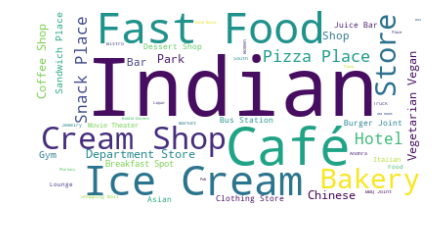

In [181]:
# generate the word cloud
venue_wc.generate(final_str_clus1)

fig = plt.figure()
fig.set_figwidth(7) # set width
fig.set_figheight(12) # set height

# display the word cloud
plt.imshow(venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Word cloud for cluster 0

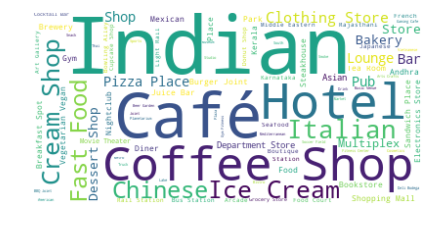

In [182]:
# generate the word cloud
venue_wc.generate(final_str_clus0)

fig = plt.figure()
fig.set_figwidth(7) # set width
fig.set_figheight(12) # set height

# display the word cloud
plt.imshow(venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()